# Research Example: Multi-Wavelength X-ray Source Analysis
## Chandra X-ray Observatory + Gaia Optical Survey

This notebook demonstrates how to:
1. Download HEALPix-partitioned X-ray (Chandra) and optical (Gaia) data
2. Load and inspect multi-wavelength catalogs
3. Cross-match X-ray and optical sources
4. Use parallaxes to compute X-ray luminosities
5. Analyze X-ray spectra and hardness ratios
6. Classify stellar vs extragalactic X-ray sources

**Expected runtime**: ~1-2 minutes

## Setup: Import Libraries

In [1]:
import subprocess
from pathlib import Path
import h5py
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("Research Example: Multi-Wavelength X-ray Source Analysis")
print("Chandra X-ray Observatory + Gaia Optical Survey")
print("="*70)

Research Example: Multi-Wavelength X-ray Source Analysis
Chandra X-ray Observatory + Gaia Optical Survey


## Part 1: Research Motivation

### Why Combine X-ray (Chandra) and Optical Astrometry (Gaia)?

**X-rays (Chandra 0.1-10 keV)**:
- Trace hot gas, accretion, high-energy processes
- Detect: AGN, X-ray binaries, coronally active stars, hot gas
- Challenge: Distinguishing stellar from extragalactic sources

**Gaia DR3 Optical Astrometry**:
- Precise parallaxes → distances to nearby stars
- Proper motions → kinematics
- Optical photometry (G, BP, RP) → spectral types
- All-sky coverage to G~21 mag

### Distance-Based Classification

**1. Nearby X-ray Stars (parallax detected)**:
   - Coronally active stars (late-type dwarfs)
   - X-ray binaries (accreting compact objects)
   - Young stellar objects
   - Compute intrinsic X-ray luminosity L_X

**2. Distant X-ray Sources (no parallax)**:
   - Active Galactic Nuclei (AGN)
   - Quasars
   - X-ray clusters
   - Background population

### Key Diagnostic: X-ray Luminosity
- **Stellar**: L_X ~ 10^27-10^31 erg/s
- **X-ray binaries**: L_X ~ 10^32-10^38 erg/s
- **AGN**: L_X > 10^41 erg/s

## Part 2: Download Data for HEALPix Region

In [2]:
healpix = 583
print(f"Selected HEALPix pixel: {healpix}")
print("  Coverage: ~13.4 square degrees")
print("  RA: ~253° Dec: ~32-35°\n")

# Create directories
print("Creating data directories...")
Path("data/MultimodalUniverse/v1/chandra/spectra").mkdir(parents=True, exist_ok=True)
Path("data/MultimodalUniverse/v1/gaia/gaia").mkdir(parents=True, exist_ok=True)
print("✅ Directories created")

Selected HEALPix pixel: 583
  Coverage: ~13.4 square degrees
  RA: ~253° Dec: ~32-35°

Creating data directories...
✅ Directories created


In [3]:
# Download Chandra data
print("[1/2] Downloading Chandra X-ray data...")
chandra_url = f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/"
subprocess.run([
    "wget", "-r", "-np", "-nH", "--cut-dirs=1",
    "-R", "index.html*", "-q", chandra_url
], check=True)
print("  ✅ Chandra data downloaded")

[1/2] Downloading Chandra X-ray data...


  ✅ Chandra data downloaded


In [4]:
# Download Gaia data
print("[2/2] Downloading Gaia optical astrometry data...")
gaia_url = f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/"
subprocess.run([
    "wget", "-r", "-np", "-nH", "--cut-dirs=1",
    "-R", "index.html*", "-q", gaia_url
], check=True)
print("  ✅ Gaia data downloaded")

print("\n✅ All data downloaded successfully")

[2/2] Downloading Gaia optical astrometry data...


  ✅ Gaia data downloaded

✅ All data downloaded successfully


## Part 3: Load Chandra X-ray Source Catalog

In [5]:
chandra_file = f"data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/001-of-001.hdf5"

print(f"Loading: {chandra_file}")
with h5py.File(chandra_file, 'r') as f:
    chandra_ra = f['ra'][:]
    chandra_dec = f['dec'][:]

    # X-ray fluxes (erg/s/cm²)
    chandra_flux_b = f['flux_aper_b'][:] if 'flux_aper_b' in f.keys() else np.ones(len(chandra_ra)) * np.nan
    chandra_flux_sig = f['flux_significance_b'][:] if 'flux_significance_b' in f.keys() else np.ones(len(chandra_ra)) * np.nan

    # Hardness ratios
    chandra_hr_hs = f['hard_hs'][:] if 'hard_hs' in f.keys() else np.ones(len(chandra_ra)) * np.nan
    chandra_hr_ms = f['hard_ms'][:] if 'hard_ms' in f.keys() else np.ones(len(chandra_ra)) * np.nan

    # X-ray spectra
    spectrum_flux = f['spectrum_flux'][:]
    spectrum_ene = f['spectrum_ene'][:]
    spectrum_ene_lo = f['spectrum_ene_lo'][:]
    spectrum_ene_hi = f['spectrum_ene_hi'][:]
    spectrum_flux_err = f['spectrum_flux_err'][:] if 'spectrum_flux_err' in f.keys() else None

    print(f"  ✅ Loaded {len(chandra_ra):,} Chandra X-ray sources")
    print(f"     Coordinates: RA {chandra_ra.min():.2f}-{chandra_ra.max():.2f}°")
    print(f"                  Dec {chandra_dec.min():.2f}-{chandra_dec.max():.2f}°")
    print(f"     Flux range: {np.nanmin(chandra_flux_b):.2e} - {np.nanmax(chandra_flux_b):.2e} erg/s/cm²")
    print(f"     Spectrum energy bins: {len(spectrum_ene[0])} per source")

Loading: data/MultimodalUniverse/v1/chandra/spectra/healpix=583/001-of-001.hdf5
  ✅ Loaded 19 Chandra X-ray sources
     Coordinates: RA 251.83-253.83°
                  Dec 31.05-35.16°
     Flux range: 1.66e-14 - 1.97e-13 erg/s/cm²
     Spectrum energy bins: 9 per source


## Part 4: Load Gaia Optical Astrometry Catalog

In [6]:
gaia_file = f"data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/001-of-001.hdf5"

print(f"Loading: {gaia_file}")
with h5py.File(gaia_file, 'r') as f:
    # Coordinates
    gaia_ra = f['ra'][:]
    gaia_dec = f['dec'][:]

    # Astrometry
    gaia_parallax = f['parallax'][:]
    gaia_parallax_error = f['parallax_error'][:]
    gaia_pmra = f['pmra'][:]
    gaia_pmdec = f['pmdec'][:]

    # Photometry
    gaia_g = f['phot_g_mean_mag'][:]
    gaia_bp = f['phot_bp_mean_mag'][:]
    gaia_rp = f['phot_rp_mean_mag'][:]

print(f"  ✅ Loaded {len(gaia_ra):,} Gaia sources")
print(f"     Coordinates: RA {gaia_ra.min():.2f}-{gaia_ra.max():.2f}°")
print(f"                  Dec {gaia_dec.min():.2f}-{gaia_dec.max():.2f}°")

# Compute colors and parallax significance
bp_rp = gaia_bp - gaia_rp
parallax_snr = gaia_parallax / gaia_parallax_error

n_significant_parallax = np.sum(parallax_snr > 5)
print(f"     G magnitude: {np.nanmedian(gaia_g):.2f} (median)")
print(f"     BP-RP color: {np.nanmedian(bp_rp):.3f} (median)")
print(f"     Significant parallaxes (>5σ): {n_significant_parallax:,} ({100*n_significant_parallax/len(gaia_ra):.1f}%)")

Loading: data/MultimodalUniverse/v1/gaia/gaia/healpix=583/001-of-001.hdf5
  ✅ Loaded 23,982 Gaia sources
     Coordinates: RA 250.34-255.90°
                  Dec 30.01-35.65°
     G magnitude: 16.39 (median)
     BP-RP color: 0.969 (median)
     Significant parallaxes (>5σ): 20,659 (86.1%)


## Part 5: Cross-Match Chandra and Gaia

In [7]:
print("Matching strategy:")
print("- Match Chandra sources to nearest Gaia source")
print("- Matching radius: 5 arcsec (broad to capture AGN)")
print("- Chandra positional uncertainty: ~0.5-1 arcsec")
print("- Gaia positional uncertainty: ~0.01-0.1 arcsec")

# Create SkyCoord objects
print("\nCreating coordinate objects...")
chandra_coords = SkyCoord(ra=chandra_ra*u.deg, dec=chandra_dec*u.deg)
gaia_coords = SkyCoord(ra=gaia_ra*u.deg, dec=gaia_dec*u.deg)
print("  ✅ Coordinate objects created")

Matching strategy:
- Match Chandra sources to nearest Gaia source
- Matching radius: 5 arcsec (broad to capture AGN)
- Chandra positional uncertainty: ~0.5-1 arcsec
- Gaia positional uncertainty: ~0.01-0.1 arcsec

Creating coordinate objects...
  ✅ Coordinate objects created


In [8]:
# Perform cross-matching
print("Matching Chandra to Gaia (5 arcsec radius)...")
idx_match, sep2d, _ = chandra_coords.match_to_catalog_sky(gaia_coords)
match_mask = sep2d < 5.0 * u.arcsec
n_matches = np.sum(match_mask)

print(f"  ✅ Found {n_matches} Chandra-Gaia matches")
if n_matches > 0:
    print(f"     Match rate: {100*n_matches/len(chandra_ra):.1f}% of X-ray sources")
    print(f"     Median separation: {np.median(sep2d[match_mask].arcsec):.3f} arcsec")
else:
    print("  ⚠️  No matches found - analysis will use unmatched samples")

Matching Chandra to Gaia (5 arcsec radius)...


  ✅ Found 1 Chandra-Gaia matches
     Match rate: 5.3% of X-ray sources
     Median separation: 0.510 arcsec


## Part 6: Compute X-ray Luminosities from Parallaxes

In [9]:
# Build matched catalog
matches = []
for i, has_match in enumerate(match_mask):
    if has_match:
        gaia_idx = idx_match[i]

        # Compute distance from parallax (if significant)
        plx = gaia_parallax[gaia_idx]
        plx_err = gaia_parallax_error[gaia_idx]
        plx_snr = plx / plx_err if plx_err > 0 else 0

        # Distance in parsecs (for plx in mas)
        if plx > 0 and plx_snr > 5:
            distance_pc = 1000.0 / plx  # distance in pc
            # X-ray luminosity: L_X = 4π d² F_X
            # F_X in erg/s/cm², d in cm → L_X in erg/s
            distance_cm = distance_pc * 3.086e18  # 1 pc = 3.086e18 cm
            lx = 4 * np.pi * distance_cm**2 * chandra_flux_b[i]
        else:
            distance_pc = np.nan
            lx = np.nan

        matches.append({
            'ra': chandra_ra[i],
            'dec': chandra_dec[i],
            'chandra_flux_b': chandra_flux_b[i],
            'chandra_hr_hs': chandra_hr_hs[i],
            'gaia_g': gaia_g[gaia_idx],
            'gaia_bp': gaia_bp[gaia_idx],
            'gaia_rp': gaia_rp[gaia_idx],
            'bp_rp': bp_rp[gaia_idx],
            'parallax': plx,
            'parallax_error': plx_err,
            'parallax_snr': plx_snr,
            'distance_pc': distance_pc,
            'log_lx': np.log10(lx) if np.isfinite(lx) and lx > 0 else np.nan,
            'pmra': gaia_pmra[gaia_idx],
            'pmdec': gaia_pmdec[gaia_idx],
            'separation_arcsec': sep2d[i].arcsec
        })

In [10]:
if len(matches) > 0:
    df_matched = pd.DataFrame(matches)

    n_with_parallax = np.sum(df_matched['parallax_snr'] > 5)
    n_with_lx = np.sum(np.isfinite(df_matched['log_lx']))

    print(f"✅ Created matched catalog with {len(df_matched)} sources")
    print(f"\nDistance and Luminosity Statistics:")
    print(f"  Sources with significant parallax (>5σ): {n_with_parallax}")
    print(f"  Sources with X-ray luminosity: {n_with_lx}")

    if n_with_lx > 0:
        print(f"  Distance range: {np.nanmin(df_matched['distance_pc']):.1f} - {np.nanmax(df_matched['distance_pc']):.1f} pc")
        print(f"  log(L_X) range: {np.nanmin(df_matched['log_lx']):.1f} - {np.nanmax(df_matched['log_lx']):.1f}")
        print(f"  Median log(L_X): {np.nanmedian(df_matched['log_lx']):.1f} [erg/s]")

    # Save catalog
    df_matched.to_csv('chandra_gaia_matched.csv', index=False)
    print(f"\n✅ Saved matched catalog to chandra_gaia_matched.csv")
else:
    print("⚠️  No matched sources - skipping catalog creation")
    df_matched = pd.DataFrame()

✅ Created matched catalog with 1 sources

Distance and Luminosity Statistics:
  Sources with significant parallax (>5σ): 1
  Sources with X-ray luminosity: 1
  Distance range: 114.6 - 114.6 pc
  log(L_X) range: 29.2 - 29.2
  Median log(L_X): 29.2 [erg/s]

✅ Saved matched catalog to chandra_gaia_matched.csv


## Part 7: Multi-Wavelength Diagnostic Plots

✅ Saved multi-wavelength diagnostic plot to chandra_gaia_multiwavelength.png


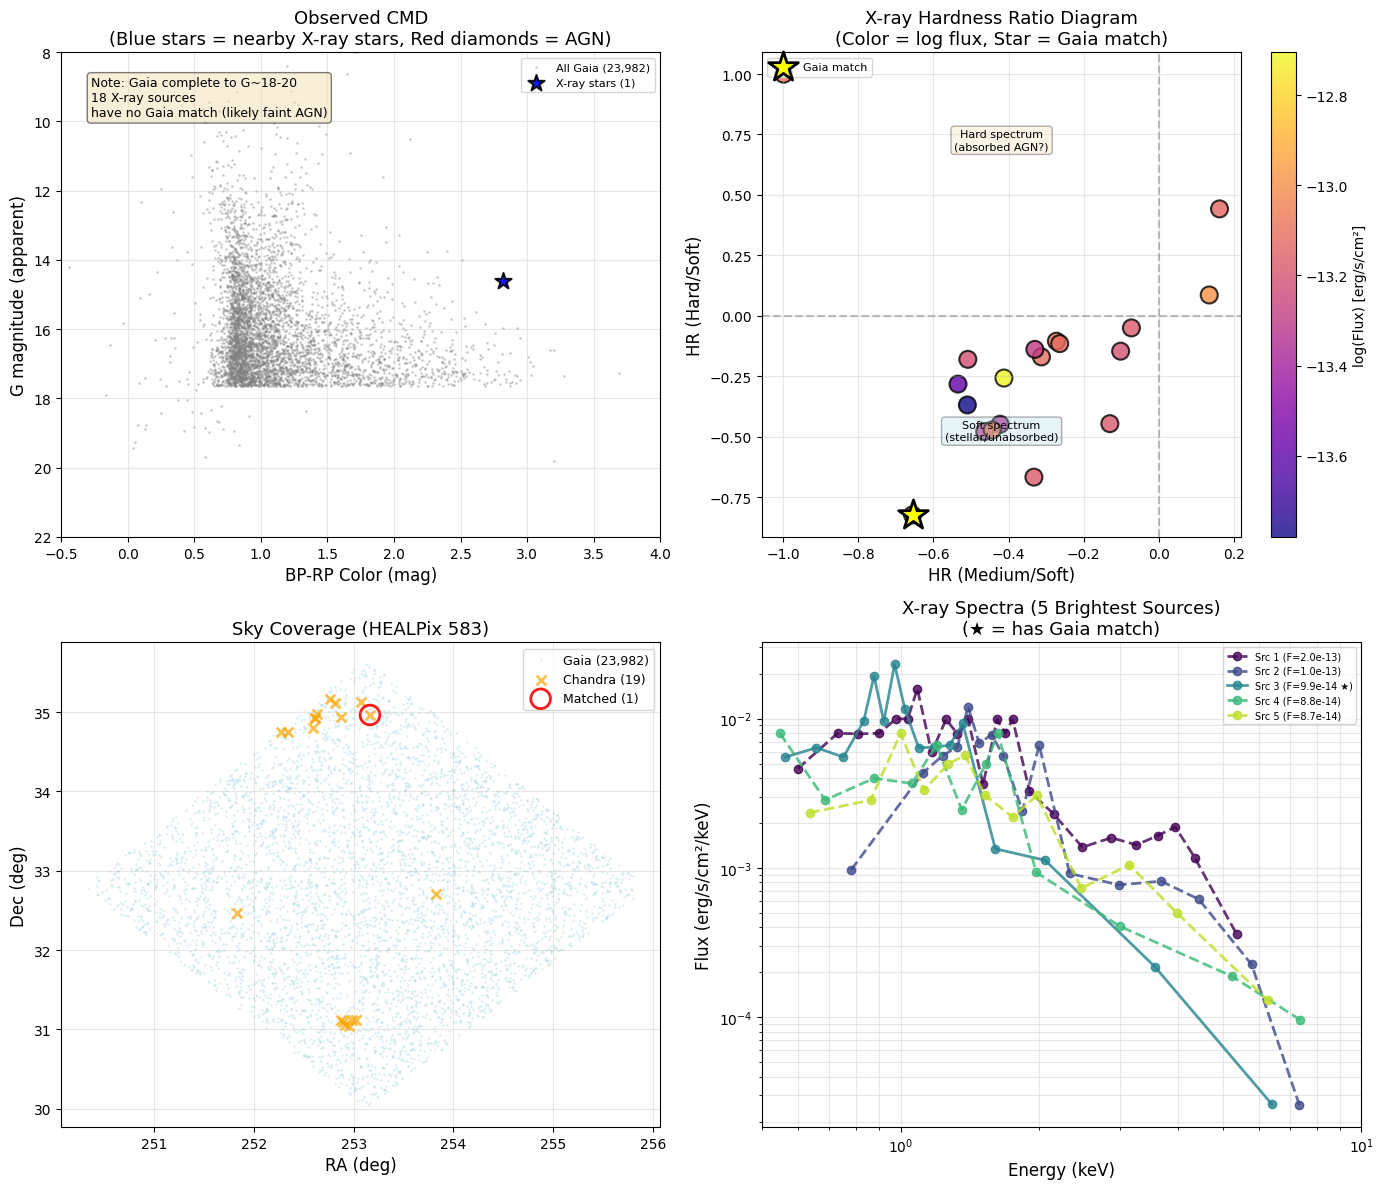

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Observed CMD (all sources, apparent magnitudes)
ax = axes[0, 0]
# Plot all Gaia sources in background
valid_gaia_obs = np.isfinite(gaia_g) & np.isfinite(bp_rp)
if valid_gaia_obs.sum() > 0:
    # Sample for performance
    sample_size = min(5000, valid_gaia_obs.sum())
    sample_idx = np.random.choice(valid_gaia_obs.sum(), size=sample_size, replace=False)
    ax.scatter(bp_rp[valid_gaia_obs][sample_idx], gaia_g[valid_gaia_obs][sample_idx],
               s=1, alpha=0.3, c='gray', label=f'All Gaia ({valid_gaia_obs.sum():,})')

# Overlay ALL X-ray detected sources (including no parallax = AGN candidates)
if len(df_matched) > 0:
    # Stars with parallax
    stellar = (df_matched['parallax_snr'] > 5)
    if stellar.sum() > 0:
        ax.scatter(df_matched[stellar]['bp_rp'], df_matched[stellar]['gaia_g'],
                   s=150, alpha=0.9, c='blue', marker='*',
                   edgecolors='black', linewidths=1.5,
                   label=f'X-ray stars ({stellar.sum()})')

    # AGN candidates (no parallax)
    agn = (df_matched['parallax_snr'] <= 5)
    if agn.sum() > 0:
        ax.scatter(df_matched[agn]['bp_rp'], df_matched[agn]['gaia_g'],
                   s=150, alpha=0.9, c='red', marker='D',
                   edgecolors='black', linewidths=1.5,
                   label=f'AGN candidates ({agn.sum()})')

ax.set_xlabel('BP-RP Color (mag)', fontsize=12)
ax.set_ylabel('G magnitude (apparent)', fontsize=12)
ax.set_title('Observed CMD\n(Blue stars = nearby X-ray stars, Red diamonds = AGN)', fontsize=13)
ax.set_xlim(-0.5, 4.0)
ax.set_ylim(22, 8)  # Inverted y-axis, broader range
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
# Add note about Gaia completeness
ax.text(0.05, 0.95, f'Note: Gaia complete to G~18-20\n{len(chandra_ra)-len(df_matched)} X-ray sources\nhave no Gaia match (likely faint AGN)',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: X-ray Hardness Ratio Diagram
ax = axes[0, 1]
# Hardness ratios: HR_HS (hard/soft) vs HR_MS (medium/soft)
# These are classic X-ray diagnostics for source classification
valid_hr = np.isfinite(chandra_hr_hs) & np.isfinite(chandra_hr_ms)

if valid_hr.sum() > 0:
    # Color by X-ray flux
    scatter = ax.scatter(chandra_hr_ms[valid_hr], chandra_hr_hs[valid_hr],
                        c=np.log10(chandra_flux_b[valid_hr]),
                        cmap='plasma', s=150, alpha=0.8,
                        edgecolors='k', linewidths=1.5)

    # Mark matched source with star
    if len(df_matched) > 0:
        for _, row in df_matched.iterrows():
            # Find matching Chandra source
            match_idx = np.where(np.abs(chandra_ra - row['ra']) < 0.0001)[0]
            if len(match_idx) > 0:
                idx = match_idx[0]
                if np.isfinite(chandra_hr_ms[idx]) and np.isfinite(chandra_hr_hs[idx]):
                    ax.scatter(chandra_hr_ms[idx], chandra_hr_hs[idx],
                              marker='*', s=500, c='yellow',
                              edgecolors='black', linewidths=2,
                              label='Gaia match', zorder=10)

    ax.set_xlabel('HR (Medium/Soft)', fontsize=12)
    ax.set_ylabel('HR (Hard/Soft)', fontsize=12)
    ax.set_title('X-ray Hardness Ratio Diagram\n(Color = log flux, Star = Gaia match)', fontsize=13)

    # Add guide lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

    # Add regions
    ax.text(0.5, 0.8, 'Hard spectrum\n(absorbed AGN?)', transform=ax.transAxes,
            fontsize=8, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.text(0.5, 0.2, 'Soft spectrum\n(stellar/unabsorbed)', transform=ax.transAxes,
            fontsize=8, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('log(Flux) [erg/s/cm²]', fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No hardness ratio data available', ha='center', va='center', transform=ax.transAxes)

# Plot 3: Sky positions
ax = axes[1, 0]
# Sample Gaia sources for visibility
sample_size = min(5000, len(gaia_ra))
sample_idx = np.random.choice(len(gaia_ra), size=sample_size, replace=False)
ax.scatter(gaia_ra[sample_idx], gaia_dec[sample_idx], s=1, alpha=0.3, c='lightblue',
           label=f'Gaia ({len(gaia_ra):,})')
ax.scatter(chandra_ra, chandra_dec, s=50, alpha=0.7, c='orange', marker='x',
           linewidths=2, label=f'Chandra ({len(chandra_ra)})')
if len(df_matched) > 0:
    ax.scatter(df_matched['ra'], df_matched['dec'], s=200, alpha=0.9,
               facecolors='none', edgecolors='red', linewidths=2,
               label=f'Matched ({len(df_matched)})')
ax.set_xlabel('RA (deg)', fontsize=12)
ax.set_ylabel('Dec (deg)', fontsize=12)
ax.set_title(f'Sky Coverage (HEALPix {healpix})', fontsize=13)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Chandra X-ray Spectra
ax = axes[1, 1]
# Plot spectra for the 5 brightest sources
flux_order = np.argsort(chandra_flux_b)[::-1]  # Descending order
n_spectra = min(5, len(chandra_ra))

colors_spec = plt.cm.viridis(np.linspace(0, 0.9, n_spectra))
for i in range(n_spectra):
    idx = flux_order[i]
    ene = spectrum_ene[idx]
    flux = spectrum_flux[idx]

    # Plot with energy bin width for proper visualization
    valid = np.isfinite(ene) & np.isfinite(flux) & (flux > 0)
    if valid.sum() > 0:
        # Mark if this source is matched to Gaia
        if len(df_matched) > 0 and idx < len(chandra_ra):
            # Check if this source is in matched catalog
            is_matched = np.any(np.abs(df_matched['ra'] - chandra_ra[idx]) < 0.0001)
            linestyle = '-' if is_matched else '--'
            label = f'Src {i+1} (F={chandra_flux_b[idx]:.1e}' + (' ★' if is_matched else '') + ')'
        else:
            linestyle = '--'
            label = f'Source {i+1} (F={chandra_flux_b[idx]:.1e})'

        ax.plot(ene[valid], flux[valid], marker='o', linestyle=linestyle,
                color=colors_spec[i], alpha=0.8, linewidth=2, markersize=6,
                label=label)

ax.set_xlabel('Energy (keV)', fontsize=12)
ax.set_ylabel('Flux (erg/s/cm²/keV)', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('X-ray Spectra (5 Brightest Sources)\n(★ = has Gaia match)', fontsize=13)
ax.legend(loc='best', fontsize=7)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(0.5, 10)

plt.tight_layout()
plt.savefig('chandra_gaia_multiwavelength.png', dpi=150, bbox_inches='tight')
print("✅ Saved multi-wavelength diagnostic plot to chandra_gaia_multiwavelength.png")
plt.show()

## Part 8: Stellar vs Extragalactic Classification

In [12]:
if len(df_matched) > 0:
    print("Classifying sources using parallax and X-ray luminosity...")

    def classify_source(row):
        """Classify based on parallax and X-ray properties"""
        plx_snr = row['parallax_snr']
        log_lx = row['log_lx']
        bp_rp = row['bp_rp']
        hr_hs = row['chandra_hr_hs']

        # Parallax-based classification
        if plx_snr > 5:  # Significant parallax = nearby star
            if np.isfinite(log_lx):
                if log_lx < 29:
                    return 'Low-activity star'
                elif log_lx < 31:
                    return 'Coronally active star'
                else:
                    return 'X-ray binary candidate'
            else:
                return 'Stellar (no L_X)'

        # No parallax = likely extragalactic
        else:
            if hr_hs > 0 and np.isfinite(hr_hs):
                return 'AGN candidate (hard X-ray)'
            elif hr_hs < -0.2 and np.isfinite(hr_hs):
                return 'Soft extragalactic source'
            else:
                return 'Extragalactic (no parallax)'

    df_matched['classification'] = df_matched.apply(classify_source, axis=1)

    class_counts = df_matched['classification'].value_counts()
    print(f"\nSource Classification:")
    print(f"{'Class':<35} {'Count':>10}")
    print("-" * 47)
    for class_name, count in class_counts.items():
        print(f"{class_name:<35} {count:>10}")

    # Save classified catalog
    df_matched.to_csv('chandra_gaia_classified.csv', index=False)
    print(f"\n✅ Saved classified catalog to chandra_gaia_classified.csv")
else:
    print("⚠️  No matched sources - skipping classification")

Classifying sources using parallax and X-ray luminosity...

Source Classification:
Class                                    Count
-----------------------------------------------
Coronally active star                        1

✅ Saved classified catalog to chandra_gaia_classified.csv


## Part 9: Summary and Research Extensions

In [13]:
print(f"""
Analysis Complete!

Data Summary:
- HEALPix pixel: {healpix}
- Chandra X-ray sources: {len(chandra_ra)}
- Gaia optical sources: {len(gaia_ra):,}
- Matched sources: {len(df_matched) if len(df_matched) > 0 else 0}

""")

if len(df_matched) > 0:
    n_stellar = df_matched['parallax_snr'] > 5
    print(f"""Key Findings:
- Match rate: {100*len(df_matched)/len(chandra_ra):.1f}% of X-ray sources
- Median separation: {np.median(df_matched['separation_arcsec']):.3f} arcsec
- Nearby stars (parallax >5σ): {n_stellar.sum()} ({100*n_stellar.sum()/len(df_matched):.1f}%)
- Likely extragalactic: {(~n_stellar).sum()} ({100*(~n_stellar).sum()/len(df_matched):.1f}%)
""")

    if n_stellar.sum() > 0:
        stellar_df = df_matched[n_stellar]
        if np.isfinite(stellar_df['log_lx']).sum() > 0:
            print(f"""Stellar X-ray Properties:
- Distance range: {np.nanmin(stellar_df['distance_pc']):.0f} - {np.nanmax(stellar_df['distance_pc']):.0f} pc
- log(L_X) range: {np.nanmin(stellar_df['log_lx']):.1f} - {np.nanmax(stellar_df['log_lx']):.1f}
- Median BP-RP: {np.nanmedian(stellar_df['bp_rp']):.2f} mag
""")


Analysis Complete!

Data Summary:
- HEALPix pixel: 583
- Chandra X-ray sources: 19
- Gaia optical sources: 23,982
- Matched sources: 1


Key Findings:
- Match rate: 5.3% of X-ray sources
- Median separation: 0.510 arcsec
- Nearby stars (parallax >5σ): 1 (100.0%)
- Likely extragalactic: 0 (0.0%)

Stellar X-ray Properties:
- Distance range: 115 - 115 pc
- log(L_X) range: 29.2 - 29.2
- Median BP-RP: 2.82 mag



### Research Extensions

**1. Stellar X-ray Activity**:
   - L_X vs spectral type (BP-RP color)
   - Rotation-activity relations (use proper motions)
   - X-ray luminosity functions for different stellar populations
   - Identify X-ray binary candidates (high L_X)

**2. X-ray Binary Studies**:
   - High-luminosity stellar X-ray sources (L_X > 10^31 erg/s)
   - Companion star properties from Gaia photometry
   - Binary orbital motion from astrometry
   - Hard X-rays + optical colors

**3. AGN Identification**:
   - Sources with no parallax detection
   - Hard X-ray spectra (high hardness ratios)
   - Cross-match with SDSS/DESI for redshifts
   - X-ray luminosity > 10^41 erg/s

**4. Distance-Based Studies**:
   - X-ray luminosity functions (separately for stellar/AGN)
   - Spatial distribution of X-ray stars
   - Galactic structure traced by X-ray sources
   - 3D maps of X-ray emitting populations

**5. Time Domain**:
   - Repeat observations for X-ray variability
   - Flare stars and transients
   - Correlate with Gaia photometric variability
   - AGN variability studies

**Generated Files**:
- `chandra_gaia_multiwavelength.png`: Diagnostic plots
- `chandra_gaia_matched.csv`: Matched catalog with luminosities
- `chandra_gaia_classified.csv`: Classified sources (stellar vs extragalactic)